In [301]:
from importlib import reload
from tqdm.auto import tqdm
import pandas as pd 
from sklearn.metrics import f1_score
import jsonlines
from tqdm import tqdm
from importlib import reload
import numpy as np
import re 
from unidecode import unidecode

import sys
sys.path.insert(0, '../scripts/')
import util

In [502]:
def clean(x):
    if pd.isnull(x):
        return x
    x = x.lower()
    words_to_remove = ['the']
    for w in words_to_remove:
        x = (' %s ' % x).replace(' %s ' % w, ' ')
    x = re.sub('\s+', ' ', x)
    x = re.sub('\d+', '', x)
    for p in string.punctuation:
        x = x.replace(p, '')
    return x.strip()

def test_in(true_label, gpt3_guess):
    if pd.isnull(true_label) or pd.isnull(gpt3_guess):
        return np.nan
    
    true_label, gpt3_guess = clean(true_label), clean(gpt3_guess)
    if true_label == gpt3_guess:
        return True
    if true_label in gpt3_guess:
        return True
    if gpt3_guess in true_label:
        return True
    return False


def fix_quote_type(quote_type, sent=None):
    if sent is None:
        quote_type, sent = quote_type['quote_type'], quote_type['sent']
    CLEANR = re.compile('<.*?>')

    def cleanhtml(raw_html):
        cleantext = re.sub(CLEANR, '', raw_html)
        return cleantext

    def normalize(text):
        text = '' if pd.isnull(text) else text
        text = re.sub('\s+', ' ', text)
        return cleanhtml(unidecode(text).strip())

    quote_type_mapper = {
        '': 'NO QUOTE',
        'PUBLIC SPEECH, NOT TO JOURNO': 'PUBLIC SPEECH',
        'COMMUNICATION, NOT TO JOURNO': 'COMMUNICATION',
        'LAWSUIT': 'COURT PROCEEDING',
        'TWEET': 'SOCIAL MEDIA POST',
        'PROPOSAL': 'PROPOSAL/ORDER/LAW',
        'Other: LAWSUIT': 'COURT PROCEEDING',
        'Other: Evaluation': 'QUOTE',
        'Other: DIRECT OBSERVATION': 'DIRECT OBSERVATION',
        'Other: Campaign filing': 'PUBLISHED WORK',
        'Other: VOTE/POLL': 'VOTE/POLL',
        'Other: PROPOSAL': 'PROPOSAL/ORDER/LAW',
        'Other: Campaign Filing': 'PUBLISHED WORK',
        'Other: Data analysis': 'DIRECT OBSERVATION',
        'Other: Analysis': 'DIRECT OBSERVATION',
        'Other: LAW': 'PROPOSAL/ORDER/LAW',
        'Other: Investigation': 'DIRECT OBSERVATION',
        'Other: Database': 'PUBLISHED WORK',
        'Other: Data Analysis': 'DIRECT OBSERVATION',
        'DOCUMENT': 'PUBLISHED WORK',
    }

    q = quote_type_mapper.get(quote_type, quote_type)
    if (q == 'QUOTE'):
        if ('"' in normalize(sent)):
            return 'INDIRECT QUOTE'
        else:
            return 'DIRECT QUOTE'
    return q

to_merge_clusters = [
    ('Statement/Public Speech', ['STATEMENT', 'PUBLIC SPEECH'],),
    ('Email/Social Media', ['COMMUNICATION', 'SOCIAL MEDIA POST',],),
    ('Published Work/Press Report', [ 'PUBLISHED WORK', 'PRESS REPORT',]),
    ('Other', [ 'VOTE/POLL', 'DECLINED COMMENT', 
               #'DIRECT OBSERVATION', 
               'PRICE SIGNAL'])
]

data_to_attribute = list(jsonlines.open('../tasks/data_split_annotated_sources.jsonl'))
data_to_attribute = list(filter(lambda x: x['split'] == 'test', data_to_attribute))
data_to_attribute = list(map(lambda x: x['data'], data_to_attribute))
quote_type_counts = pd.concat(list(map(pd.DataFrame, data_to_attribute))).apply(lambda x: fix_quote_type(x['quote_type'], x['sent']), axis=1).value_counts()

def merge_cluster(res_s, quote_type_counts, output_cluster_name, to_merge):
    res = res_s[to_merge]
    counts = quote_type_counts[to_merge]
    summation = (res * counts).sum()
    avg = summation / counts.sum()
    return {output_cluster_name: avg}

def merge_all_clusters(s, full=None,
                       quote_type_counts=quote_type_counts,
                       to_merge_clusters=to_merge_clusters
                      ):
    output = {}
    if full is None:
        output['full'] = (s * quote_type_counts).sum() / quote_type_counts.sum()
    else:
        output['full'] = full
    for c, m in to_merge_clusters:
        res = merge_cluster(s, quote_type_counts, c, m)
        output.update(res)

    merged_cols = [x_i for c, x in to_merge_clusters for x_i in x]
    remaining = s[~s.index.isin(merged_cols)].rename(lambda x: x.title())
    output.update(remaining.to_dict())
    return pd.Series(output)

final_col_order = [
    'full',
    'Direct Quote',
    'Indirect Quote',
    # 
    'Statement/Public Speech',
    #
    'Email/Social Media',
    # 
    'Published Work/Press Report',
    # 
    'Other'    
]

In [487]:
def evaluate_quote_attribution(y_pred, y_true):
    y_true_df = pd.DataFrame(y_true)
    y_pred_df = (
        pd.DataFrame(y_pred)['sources']
         .apply(lambda x: sorted(x, key=lambda y: -len(y['head']))).str.get(0)
         .apply(lambda x: x['head'] if pd.notnull(x) else 'None')
        )
    
    preds_and_true = pd.concat([y_true_df, y_pred_df], axis=1)
    return (preds_and_true
     .loc[lambda df: ~df.apply(fix_quote_type, axis=1).isin(to_exclude)]
     .assign(is_match=lambda df: df.apply(lambda x: test_in(x['head'], x['sources']), axis=1))
    )
    

# Run on our data

In [4]:
annotated_data = list(jsonlines.open('../tasks/data_split_annotated_sources.jsonl'))
test_data = list(filter(lambda df: df['split'] == 'test', annotated_data))
test_data = list(map(lambda x: x['data'], test_data))

In [526]:
coref_res = list(jsonlines.open('../tasks/quote_attribution/all_annotated_sources__coref-resolved.jsonl'))
test_docs = json.load(open('../tasks/short_training_data_doc_ids.json'))['test_docs']
core_res_test = list(filter(lambda x: x[0]['doc_id'] in test_docs, coref_res))

In [527]:
method_1_sents = []

for doc in tqdm(core_res_test):
    sents = list(map(lambda x: x['sent'], doc))
    _, output_sents = util.get_quotes_method_1(sents, orig_speaking=False, return_sents=True)
    method_1_sents.append(output_sents)

100%|███████████████████████████████████████████████████████████████████| 86/86 [00:57<00:00,  1.50it/s]


In [528]:
to_exclude = [
    'NO QUOTE', 
    'NARRATIVE',
    'BACKGROUND',
    'DIRECT OBSERVATION'
]

In [529]:
def evaluate_quote_detection(preds, labels, with_attribution=True):
    pred_df = pd.DataFrame( preds)
    true_df = pd.DataFrame( labels)
    
    if with_attribution:
        y_pred = (pred_df['sources']
         .apply(lambda x: list(filter(lambda y: y['quote_type'] != 'background sentence', x)))
         .pipe(lambda df: df.str.len() > 1)
         )
    else:
        y_pred = pd.DataFrame(preds)['is_quote']
    
    quote_type = true_df.apply(lambda x: fix_quote_type(x['quote_type'], x['sent']), axis=1)
    y_true = quote_type.pipe(lambda s: ~s.isin(to_exclude))
    
    results_df = pd.concat([
        y_pred.to_frame('y_pred'),
        y_true.to_frame('y_true'),
        quote_type.to_frame('quote_type')
    ] , axis=1)
    
    if False:
        results_df = pd.concat([
             results_df.loc[lambda df: ~df['quote_type'].isin(to_exclude)],
             results_df.loc[lambda df: df['quote_type'].isin(to_exclude)]
                 .assign(y_pred=lambda df: ~df['y_pred'])
                 .assign(y_true=lambda df: ~df['y_true'])
        ])
    return results_df

In [530]:
res_df__detection__method_1 = []
for y_pred, y_true in zip(method_1_sents, test_data):
    res_df = evaluate_quote_detection(y_pred, y_true)
    res_df__detection__method_1.append(res_df)

res_df__detection__method_1 = pd.concat(res_df__detection__method_1)

In [531]:
full = res_df__detection__method_1.pipe(lambda df: f1_score(df['y_true'], df['y_pred']))

res_df_detect_final__method_1 = (res_df__detection__method_1
 .groupby('quote_type')
 .apply(lambda df: f1_score(df['y_true'], df['y_pred']))
 .pipe(lambda s: merge_all_clusters(s, full))
 .loc[final_col_order]
 .pipe(lambda s: s* 100).round(1)
)

In [532]:
res_df_detect_final__method_1

full                           64.7
Direct Quote                   71.9
Indirect Quote                 78.6
Statement/Public Speech        87.2
Email/Social Media             85.4
Published Work/Press Report    76.3
Other                          69.7
dtype: float64

In [434]:
import pyperclip
pyperclip.copy(res_df_detect_final__method_1.to_frame().T.to_latex())

/var/folders/89/6dsq1ymj63x009t6wpt25f9h0000gp/T/ipykernel_87252/108186547.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pyperclip.copy(res_df_detect_final__method_1.to_frame().T.to_latex())


In [533]:
method_2_sents = []

for doc in tqdm(core_res_test):
    sents = list(map(lambda x: x['sent'], doc))
    _, output_sents = util.get_quotes_method_2(sents, orig_speaking=False, return_sents=True)
    method_2_sents.append(output_sents)

100%|███████████████████████████████████████████████████████████████████| 86/86 [01:39<00:00,  1.15s/it]


In [534]:
res_df__detection__method_2 = []
for y_pred, y_true in zip(method_2_sents, test_data):
    res_df = evaluate_quote_detection(y_pred, y_true)
    res_df__detection__method_2.append(res_df)

res_df__detection__method_2 = pd.concat(res_df__detection__method_2)

In [535]:
full = res_df__detection__method_2.pipe(lambda df: f1_score(df['y_true'], df['y_pred']))
res_detection_final__method_2 = (res_df__detection__method_2
 .groupby('quote_type')
 .apply(lambda df: f1_score(df['y_true'], df['y_pred']))
 .pipe(lambda s: merge_all_clusters(s, full))
 .loc[final_col_order]
 .pipe(lambda s: s* 100).round(1)
)

In [536]:
print(res_detection_final__method_2.to_frame().T.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  full &  Direct Quote &  Indirect Quote &  Statement/Public Speech &  Email/Social Media &  Published Work/Press Report &  Other \\
\midrule
0 &  67.6 &          70.2 &            78.9 &                     86.1 &                81.4 &                         77.1 &   61.5 \\
\bottomrule
\end{tabular}



/var/folders/89/6dsq1ymj63x009t6wpt25f9h0000gp/T/ipykernel_87252/728961262.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res_detection_final__method_2.to_frame().T.to_latex())


## Rules for attribution

In [537]:
res_df__evaluation__method_1 = []
for y_pred, y_true in zip(method_1_sents, test_data):
    res_df = evaluate_quote_attribution(y_pred, y_true)
    res_df__evaluation__method_1.append(res_df)

In [538]:
full_res_df__evaluation__method_1 = pd.concat(res_df__evaluation__method_1)
full = full_res_df__evaluation__method_1['is_match'].mean()
(full_res_df__evaluation__method_1
 .assign(quote_type=lambda df: df.apply(fix_quote_type, axis=1))
 .groupby('quote_type')
 .apply(lambda df: df['is_match'].mean())
 .pipe(lambda s: merge_all_clusters(s, full))
 .loc[final_col_order]
 .pipe(lambda s: s* 100).round(1)
 .to_frame().T
 .pipe(lambda s: print(s.to_latex()))
)

\begin{tabular}{lrrrrrrr}
\toprule
{} &  full &  Direct Quote &  Indirect Quote &  Statement/Public Speech &  Email/Social Media &  Published Work/Press Report &  Other \\
\midrule
0 &  52.8 &          57.3 &            54.5 &                     49.8 &                49.4 &                         38.3 &   34.9 \\
\bottomrule
\end{tabular}



/var/folders/89/6dsq1ymj63x009t6wpt25f9h0000gp/T/ipykernel_87252/118403944.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  .pipe(lambda s: print(s.to_latex()))


In [541]:
res_df__evaluation__method_2 = []
for y_pred, y_true in zip(method_2_sents, test_data):
    res_df = evaluate_quote_attribution(y_pred, y_true)
    res_df__evaluation__method_2.append(res_df)

In [542]:
full_res_df__evaluation__method_2 = pd.concat(res_df__evaluation__method_2)
full = full_res_df__evaluation__method_2['is_match'].mean()
(full_res_df__evaluation__method_2
 .assign(quote_type=lambda df: df.apply(fix_quote_type, axis=1))
 .groupby('quote_type')
 .apply(lambda df: df['is_match'].mean())
 .pipe(lambda s: merge_all_clusters(s, full))
 .loc[final_col_order]
 .pipe(lambda s: s* 100).round(1) 
  .to_frame().T
 .pipe(lambda s: print(s.to_latex()))

)

\begin{tabular}{lrrrrrrr}
\toprule
{} &  full &  Direct Quote &  Indirect Quote &  Statement/Public Speech &  Email/Social Media &  Published Work/Press Report &  Other \\
\midrule
0 &  36.6 &          31.6 &            42.0 &                     56.1 &                30.3 &                         32.3 &   30.2 \\
\bottomrule
\end{tabular}



/var/folders/89/6dsq1ymj63x009t6wpt25f9h0000gp/T/ipykernel_87252/2459294640.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  .pipe(lambda s: print(s.to_latex()))


# Quootstrap

<AxesSubplot: >

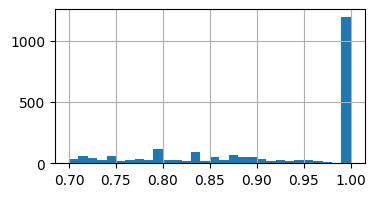

In [43]:
patterns = open('../models_other/Quotebank/quootstrap/resources/seedPatterns.txt').readlines()
patterns = list(map(lambda x: x.strip().replace('[', '').replace(']', ''), patterns))
patterns = list(map(lambda x: x.split(': '), patterns))
patterns = list(map(lambda x: (': '.join(x[:-1]), float(x[-1])), patterns))
pattern_df = pd.DataFrame(patterns, columns=['pattern', 'confidence'])
pattern_df['confidence'].hist(bins=30, figsize=(4, 2))

In [86]:
to_replace = [
    '$Q', '$*', 'QUOTE', '$S'
]

pattern_list = pattern_df['pattern'].tolist()
to_replace_re = list(map(re.escape, to_replace))

re_patterns = []
for p in pattern_list:
    p_split = re.split('|'.join(to_replace_re), p)
    p_split = list(map(re.escape, p_split))
    re_p = '*?'.join(p_split)
    re_patterns.append(re_p)

In [88]:
replace_patterns = []
for p in pattern_list:
    for r in to_replace:
        p = p.replace(r, '')
    p = re.sub('\s+', ' ', p)
    p = list(filter(lambda x: x!= '', p.split()))
    replace_patterns.append(p)

In [97]:
method_3_sents = []

for doc in tqdm(test_data):
    sents = list(map(lambda x: unidecode(x['sent']), doc))
    output_sents = []
    for sent in sents:
        found = False
        for p in replace_patterns:
            if all(map(lambda x: x in sent, p)):
                found = True
                break
        output_sents.append({'sent': sent, 'is_quote': found})
    method_3_sents.append(output_sents)
#     method_3_sents.append(output_sents)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:04<00:00, 18.12it/s]


In [99]:
res_df__detection__method_3 = []
for y_pred, y_true in zip(method_3_sents, test_data):
    res_df = evaluate_quote_detection(y_pred, y_true, with_attribution=False)
    res_df__detection__method_3.append(res_df)

res_df__detection__method_3 = pd.concat(res_df__detection__method_3)

In [101]:
res_df__detection__method_3.pipe(lambda df: f1_score(df['y_true'], df['y_pred']))

0.4581730769230769

In [570]:
t = (res_df__detection__method_3
 .groupby('quote_type').apply(lambda df: f1_score(df['y_true'], df['y_pred']))
    )

# t['DIRECT QUOTE'] = .85

(t
 .pipe(merge_all_clusters)
 .loc[final_col_order]
 .pipe(lambda s: s * 100).round(1)
 .pipe(lambda s: print(s.to_frame().T.to_latex()))
)

\begin{tabular}{lrrrrrrr}
\toprule
{} &  full &  Direct Quote &  Indirect Quote &  Statement/Public Speech &  Email/Social Media &  Published Work/Press Report &  Other \\
\midrule
0 &  33.4 &          85.0 &            81.3 &                     51.3 &                58.6 &                         33.1 &    3.0 \\
\bottomrule
\end{tabular}



/var/folders/89/6dsq1ymj63x009t6wpt25f9h0000gp/T/ipykernel_87252/1322722860.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  .pipe(lambda s: print(s.to_frame().T.to_latex()))


# QuoBERT

In [116]:
import json, glob
import jsonlines

quotebank_res_files = glob.glob('../models_other/Quotebank/results/output*')

all_quotebank_results = []
for f in quotebank_res_files:
    quotebank_output = list(jsonlines.open(f))
    all_quotebank_results += quotebank_output

In [150]:
all_quotebank_results_df = pd.DataFrame(all_quotebank_results, columns=['url', 'quotebank_results'])

In [132]:
annotations = list(jsonlines.open('../tasks/annotated_sources_with_urls.jsonl'))

In [147]:
annotations_df = pd.DataFrame(annotations).assign(url=lambda df: df['url'].str.split('nytimes.com').str.get(1))

In [158]:
data_split = json.load(open('../tasks/short_training_data_doc_ids.json'))

In [175]:
data_split_df = (pd.Series(data_split)
 .apply(pd.Series)
 .unstack()
 .dropna()
 .reset_index()
 .assign(split=lambda df: df['level_1'].str.split('_').str.get(0))
 .assign(doc_id=lambda df: df[0].astype(int))
 [['doc_id', 'split']]
)

In [177]:
full_quotebank_df = (annotations_df
 .merge(all_quotebank_results_df, left_on='url', right_on='url')
 .merge(data_split_df, right_on='doc_id', left_on='doc_id')
)

In [217]:
import string
from polyleven import levenshtein
import re
from unidecode import unidecode
from copy import copy
def process_sent(sent):
    sent = copy(sent)
    sent = unidecode(sent)
    for p in string.punctuation:
        sent = sent.replace(p, ' ')
    sent = re.sub('\s+', ' ', sent)
    return sent.lower()

def find_quote_in_sent(quote, sent):
    quote = process_sent(quote)
    sent = process_sent(sent)
    if len(sent) <= 2:
        return False
    if (quote in sent) or (sent in quote):
        return True
    return levenshtein( quote, sent) < 5

In [239]:
our_annotations, quotebank_annotations, split = full_quotebank_df.iloc[0][['data', 'quotebank_results', 'split']]

In [328]:
qb_annotated_quote_dfs = []
not_found_dfs = []

num_not_found = 0
num_total = 0

for idx, (our_annotations, quotebank_annotations, split, url) in (
    full_quotebank_df[['data', 'quotebank_results', 'split', 'url']].iterrows()
):
    annotated_quotes = []
    for sent in our_annotations:
        quote_packet = {
            'doc_id': sent['doc_id'],
            'sent': sent['sent'],
            'sent_idx': sent['sent_idx'],
            'our_head': sent['head'],
            'quote_type': fix_quote_type(sent['quote_type'], sent['sent'])
        }

        for quote in quotebank_annotations['quotations']:
            if find_quote_in_sent(quote['quotation'], sent['sent']):
                quote_packet.update({
                    'qb_quote_id': quote['quoteID'],
                    'qb_quote': quote['quotation'],
                    'qb_quote_local_speaker': quote['localTopSpeaker'],
                    'qb_quote_local_probs': quote['localProbas'],
                    'qb_quote_global_speaker': quote['globalTopSpeaker'],
                    'qb_quote_global_probs': quote['globalProbas'],
                })
                break
        annotated_quotes.append(quote_packet)

    annotated_quotes_df = pd.DataFrame(annotated_quotes)
    quote_bank_df = pd.DataFrame(quotebank_annotations['quotations'])
    
    if 'qb_quote_id' not in annotated_quotes_df.columns:
        print(f'none found (f{split})...')
        continue
        
    qb_not_found = quote_bank_df.loc[lambda df: ~df['quoteID'].isin(annotated_quotes_df['qb_quote_id'])]
    qb_not_found = qb_not_found.assign(url=url)
    not_found_dfs.append(qb_not_found)
    
    num_not_found += qb_not_found.shape[0]
    num_total += quote_bank_df.shape[0]
    
    annotated_quotes_df = annotated_quotes_df.assign(split=split).assign(url=url)
    qb_annotated_quote_dfs.append(annotated_quotes_df)

none found (ftrain)...
none found (ftest)...
none found (ftrain)...
none found (ftrain)...
none found (ftrain)...
none found (ftrain)...
none found (ftrain)...


In [329]:
all_not_found_dfs = pd.concat(not_found_dfs)

In [273]:
full_quotebank_df.loc[lambda df: df['url'] == all_not_found_dfs['url'].iloc[0]]

,data,doc_id,url,quotebank_results,split
6,[{'sent': 'President Trump ’s announcement on ...,13,/2017/07/26/us/politics/trans-military-trump-t...,"{'articleID': '2017072615_00853126_W', 'quotat...",train


In [343]:
full_quotebank_df['doc_id'].unique().shape 

(240,)

In [344]:
240 - 79 - 22

139

In [331]:
full_quotebank_df.loc[lambda df: df['url'].isin(all_not_found_dfs['url'])]['split'].value_counts()

train    79
test     22
Name: split, dtype: int64

In [332]:
all_matched_res_dfs= (
    pd.concat(qb_annotated_quote_dfs)
        .assign(our_head=lambda df: df['our_head'].apply(lambda x: x if x != '' else 'None'))
)

In [333]:
all_matched_res_dfs= (
    all_matched_res_dfs
     .assign(is_quote_qb=lambda df: df[['qb_quote_global_speaker', 'qb_quote_local_speaker']].notnull().any(axis=1))
     .assign(is_quote_us=lambda df: ~df['quote_type'].isin(to_exclude))
     .assign(is_match_global=lambda df: df.apply(lambda x: test_in(x['our_head'], x['qb_quote_global_speaker']), axis=1).fillna(False))
     .assign(is_match_local=lambda df: df.apply(lambda x: test_in(x['our_head'], x['qb_quote_local_speaker']), axis=1).fillna(False))
)

In [334]:
all_matched_res_dfs.pipe(lambda df: f1_score(df['is_quote_us'], df['is_quote_qb']))

0.3737654320987654

In [335]:
all_matched_res_dfs.loc[lambda df: df['is_quote_us'] == True]['is_match_local'].mean()

0.11856951615987761

In [550]:
(all_matched_res_dfs
 .loc[lambda df: df['is_quote_us'] == True]
 .groupby('quote_type')['is_match_local']
 .mean()
 .pipe(merge_all_clusters)
 .loc[final_col_order]
 .pipe(lambda s: s * 100).round(1)
 .to_frame().T
 .pipe(lambda df: print(df.to_latex()))
)

\begin{tabular}{lrrrrrrr}
\toprule
{} &  full &  Direct Quote &  Indirect Quote &  Statement/Public Speech &  Email/Social Media &  Published Work/Press Report &  Other \\
\midrule
0 &   5.5 &           9.9 &            16.0 &                     16.4 &                17.7 &                          4.3 &    0.5 \\
\bottomrule
\end{tabular}



/var/folders/89/6dsq1ymj63x009t6wpt25f9h0000gp/T/ipykernel_87252/2748822167.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  .pipe(lambda df: print(df.to_latex()))


In [552]:
(all_matched_res_dfs
 .loc[lambda df: df['is_quote_us'] == True]
 .groupby('quote_type')['is_match_local']
 .mean()).shape 

(13,)

In [556]:
all_matched_res_dfs['quote_type'].value_counts().shape 

(17,)

In [23]:
## method 3 has already been performed
import json
import pandas as pd 
input_datum = json.load(open('../app/data/input_data/0/to-annotate-0.json'))
pd.DataFrame(input_datum['html_data']).head(2)

In [ ]:
docs_to_calculate_metrics_over = glob.glob('../app/data/output_data_affil-role/*/*')
docs_to_calculate_metrics_over = list(filter(lambda x: re.search('\d+', x.split('/')[-1])[0] in test_docs, docs_to_calculate_metrics_over))

In [ ]:
all_method_1_to_check, all_method_2_to_check, all_method_3_to_check = [], [], []
all_metrics_method_1, all_metrics_method_2, all_metrics_method_3 = [], [], []
for fname in tqdm(docs_to_calculate_metrics_over):
    checked_name = fname.replace('output', 'checked').replace('annotated', 'checked')
    if checked_name in checked_files:
        fname = checked_name

    input_fname = (
        fname
            .replace('checked_', 'input_').replace('output_', 'input_')
            .replace('_affil-role', '')
            .replace('checked', 'to-annotate').replace('annotated', 'to-annotate')
    )

    with open(fname) as f:
        annotated_data = json.load(f)
        
    with open(input_fname) as f:
        input_data = json.load(f)

    one_doc_annotated_df = (
        pd.DataFrame(annotated_data['data']['row_data'])
         .applymap(lambda x: x['field_value'] if isinstance(x, dict) else x)
         [['row_idx', 'head', 'quote_type', 'source_type']].fillna('')
    )

    one_doc_input_df = pd.DataFrame(input_data['html_data'])[['sent_idx', 'sent']]
    
    to_check_df = get_sent_labels_old_methods(method_2, one_doc_input_df, one_doc_annotated_df)
    metrics_dict = calculate_metrics(to_check_df)
    all_metrics_method_2.append(metrics_dict)
    all_method_2_to_check.append(to_check_df)
    
    to_check_df = get_sent_labels_old_methods(method_1, one_doc_input_df, one_doc_annotated_df)
    to_check_df = to_check_df.merge(one_doc_input_df, left_on='row_idx', right_on='sent_idx')
    all_method_1_to_check.append(to_check_df)
    
    metrics_dict = calculate_metrics(to_check_df)
    all_metrics_method_1.append(metrics_dict)
    
    
    method_3_pred_df = (
        pd.DataFrame(input_data['html_data'])[['type', 'head']]
            .fillna('')
            .rename(columns={'head': 'pred_head', 'type':'pred_sent_type'})
    )

    method_3_df_to_check = pd.concat([one_doc_annotated_df, method_3_pred_df], axis=1)
    all_method_3_to_check.append(method_3_df_to_check)
    method_3_metrics_dict = calculate_metrics(method_3_df_to_check)
    all_metrics_method_3.append(method_3_metrics_dict)